In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np
import matplotlib.pyplot as plt

from utils.file import VideoFile
from utils.load import load_videos
from utils.ssim import ssim, msssim
import math

%load_ext autoreload
%autoreload 2

import multiprocessing
multiprocessing.set_start_method('spawn', force=True) # OpenCV in dataloader

import matplotlib.pyplot as plt
import gc

ToImage = T.ToPILImage()

https://stats.stackexchange.com/questions/219914/rnns-when-to-apply-bptt-and-or-update-weights/220111

https://pdfs.semanticscholar.org/9a98/4104e5d3ab9c9f5d27e50d99e5ea1fb25429.pdf - Convolutional LSTMs

https://github.com/pytorch/examples/tree/master/word_language_model - Pytorch LSTM example

https://arxiv.org/abs/1801.10308 - Nested LSTMs

http://cs231n.stanford.edu/reports/2017/pdfs/423.pdf - Previous 231

https://arxiv.org/pdf/1601.06759.pdf - PixelRNN

https://arxiv.org/pdf/1608.05148.pdf - Google Image Compression

https://arxiv.org/abs/1511.06085 - Baseline for previous paper

https://arxiv.org/abs/1512.03385 - Deep Residual Learning (ResNet)

https://arxiv.org/pdf/1708.00838v1.pdf - Image Compression layer on top of existing codecs

https://www.cv-foundation.org/openaccess/content_iccv_2015/papers/Tran_Learning_Spatiotemporal_Features_ICCV_2015_paper.pdf - 3D convolutions, suggests that transfer learning from single image stuff not so useful

https://arxiv.org/pdf/1805.12295.pdf - Newer google image compression, good references

https://arxiv.org/pdf/1804.09869.pdf - Video compression

Break training data into 30 frame chunks: chunks may be unnecessary variable lengths supported

30 Frame chunks: batch size 8ish (assuming 16 bit floats)

Nested LSTM?

LSTMCell

PixelCNN style context

In [2]:
data_loader = load_videos("seqs/objective-2-slow/list.txt")
dtype = torch.cuda.FloatTensor 
#dtype = torch.FloatTensor
device = torch.device("cuda:0")

# Simple explicit state strategy

Train on reference images (not reconstructions), to allow parallelizing training.

In [3]:
prev_frames = 2
num_conv = 4

In [4]:
class Squeeze(nn.Module):
    def forward(self, x):
        return x.squeeze(dim=2)
    
class Debug(nn.Module):
    def forward(self, x):
        print("Debug ")
        print(x.shape)
        return x
    
class FullCompress(nn.Module):
    def __init__(self, predictor, autoencoder):
        super(FullCompress, self).__init__()
        self.predictor = predictor
        self.autoencoder = autoencoder
    def forward(self, chunk, truth):
        pred = self.predictor(chunk)
        enc = self.autoencoder(truth)
        return pred + enc

In [5]:
layers = []
prev_channels = 3
for i in range(num_conv):
    layers.append(nn.Conv3d(prev_channels, 32, (3, 3, 3), stride=1, padding=(1, 1, 1)))
    layers.append(nn.ReLU())
    prev_channels = 32
    
layers.append(nn.Conv3d(prev_channels, 16, (3, 3, 3), stride=1, padding=(0, 1, 1))) # Reduce time dimension to one
layers.append(Squeeze())
layers.append(nn.ReLU())
layers.append(nn.Conv2d(16, 8, 3, stride=1, padding=(1, 1)))
layers.append(nn.ReLU())
layers.append(nn.Conv2d(8, 3, 3, stride=1, padding=(1, 1)))
layers.append(nn.ReLU())
layers.append(nn.Conv2d(3, 3, (2, 2), stride=(2, 2), padding=0))
    
pred_model = nn.Sequential(*layers).type(dtype)

In [6]:
enc_model = nn.Sequential(
    nn.Conv2d(3, 64, 4, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 64, 8, stride=4, padding=2),
    nn.ReLU(),
    nn.Conv2d(64, 2, 3, stride=1, padding=1, groups=2),
    nn.ReLU(),
    nn.ConvTranspose2d(2, 64, 3, stride=1, padding=1, groups=2),
    nn.ReLU(),
    nn.ConvTranspose2d(64, 64, 8, stride=4, padding=2),
    nn.ReLU(),
    nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1)
).type(dtype)

In [7]:
model = FullCompress(pred_model, enc_model)

In [8]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Conv3d):
        nn.init.xavier_normal_(m.weight.data)

model.apply(weights_init)

#model.load_state_dict(torch.load("model"))

FullCompress(
  (predictor): Sequential(
    (0): Conv3d(3, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): ReLU()
    (2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (3): ReLU()
    (4): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (5): ReLU()
    (6): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (7): ReLU()
    (8): Conv3d(32, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
    (9): Squeeze()
    (10): ReLU()
    (11): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): Conv2d(8, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU()
    (15): Conv2d(3, 3, kernel_size=(2, 2), stride=(2, 2))
  )
  (autoencoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(8, 8), stride=(4, 4), padding=(2, 2))
 

In [9]:
def neg_ssim(img1, img2):
    #return -1.0*ssim(img1, img2)[0]
    return -1.0*msssim(img1, img2)
calc_loss = neg_ssim
#calc_loss = nn.MSELoss()

def evaluate(model, solver, data, truth):
    result = model(data, truth)
    
    # Fill in prediction to the current frame's context
    # Calculates loss on 64x64 area
    #big_result = data[:, :, 2, :, :].clone()
    #big_result[:, :, 32:64, 32:64] = result
    big_result = result
    
    loss = calc_loss(big_result, truth)
    
    solver.zero_grad()
    loss.backward()
    solver.step()
    
    return loss

In [10]:
def train_on_frame_chunks(solver, model, video, chunks_tall, chunks_wide, num_frames):
    for i in range(prev_frames, prev_frames+num_frames):
        subset = video[i - prev_frames:i + 1].transpose(0, 1)#.to(device).type(dtype)
        chunks = subset.view(subset.shape[0], subset.shape[1], chunks_tall, 64, chunks_wide, 64)
            
        chunks = chunks.permute(2, 4, 0, 1, 3, 5).clone().view(-1, 3, prev_frames + 1, 64, 64)
        truths = chunks[:, :, 2, 32:64, 32:64].clone()

        chunks[:, :, 2, 32:64, 32:64] = torch.zeros(32, 32)

        for data, truth in zip(chunks.split(64, 0), truths.split(64, 0)):
            data = data.type(dtype).to(device)
            truth = truth.type(dtype).to(device)
            loss = evaluate(model, solver, data, truth)
            
    print("Loss {}".format(loss))
        
def train_on_video(solver, model, video):
    num_frames = video.shape[0]
    video = F.pad(video, (0, 0, 0, 0, 0, 0, prev_frames, 0))
    
    # Display first frame of video
    img = video[2].cpu()
    plt.imshow(ToImage(img))
    plt.show()
    
    num_ctx_tall_even = video.shape[2] // 64
    num_ctx_wide_even = video.shape[3] // 64
    
    video_even = video[:, :, 0:num_ctx_tall_even*64, 0:num_ctx_wide_even*64]
    train_on_frame_chunks(solver, model, video_even, num_ctx_tall_even, num_ctx_wide_even, num_frames)
    
    num_ctx_tall_odd = (video.shape[2] - 32) // 64
    num_ctx_wide_odd = (video.shape[3] - 32) // 64
    video_odd = video[:, :, 32:32+num_ctx_tall_odd*64, 32:32+num_ctx_wide_odd*64]
    train_on_frame_chunks(solver, model, video_odd, num_ctx_tall_odd, num_ctx_wide_odd, num_frames)

In [11]:
def train(model, video_set, lr, num_epochs):
    for epoch in range(num_epochs):
        #solver = optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay=1e-5)
        #lr /= 2
        for videos in video_set:
            solver = optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay=1e-2)
            gc.collect()
            lr = 0.9*lr
            for i in range(len(videos)):
                video = videos[i]
                train_on_video(solver, model, video)
        

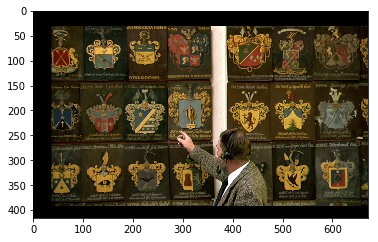

Loss -0.3961032032966614
Loss -0.5639849305152893


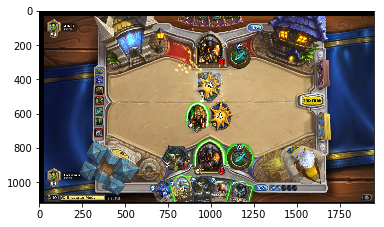

Loss -0.7569763660430908
Loss -0.7857310175895691


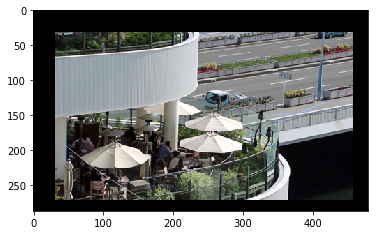

Loss -0.7975480556488037
Loss -0.6884217262268066


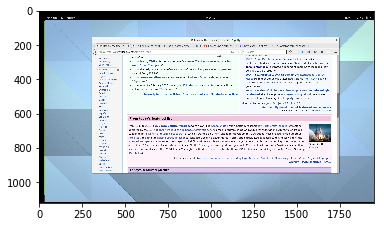

Loss -0.9768888354301453
Loss -0.9663245677947998


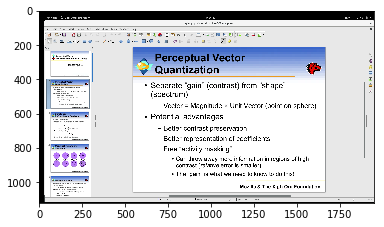

KeyboardInterrupt: 

In [12]:
train(model, data_loader, 5e-4, 10)

In [17]:
model.zero_grad()
#torch.save(model.state_dict(), "model_ssim_auto")

In [19]:
model.load_state_dict(torch.load("model_ssim_auto"))
model = model.eval()

In [20]:
def test(model, video):
    print(video.shape)
    residuals = []
    num_frames = video.shape[0]
    height = video.shape[2]
    width = video.shape[3]
    num_chunks_tall = height // 32
    num_chunks_wide = width // 32
    ctx = torch.zeros(1, 3, prev_frames + 1, height, width).type(dtype)
    for f in range(num_frames):
        print("Frame {}".format(f))
        pred_frame = torch.zeros(3, height, width).type(dtype)
        res_frame = torch.zeros(3, height, width).type(dtype)
        for i in range(num_chunks_tall - 1):
            for j in range(num_chunks_wide - 1):
                sub_ctx = ctx[:, :, :, i*32:i*32+64, j*32:j*32+64]
                truth = video[f, :, i*32+32:i*32+64, j*32+32:j*32+64].type(dtype)
                truth = truth.view(1, *truth.shape)
                pred = model(sub_ctx, truth)
                
                res = truth - pred[0]
                pred_frame[:, i*32+32:i*32+64, j*32+32:j*32+64] = pred[0]
                res_frame[:, i*32+32:i*32+64, j*32+32:j*32+64] = res
                sub_ctx[0, :, 2, 32:64, 32:64] = truth
                
        plt.imshow(ToImage(video[f]))
        plt.show()
        plt.imshow(ToImage(pred_frame.cpu()))
        plt.show()
        res_frame = -1.0*torch.max(torch.abs(res_frame), 0, keepdim=True)[0]
        print(res_frame.shape)
        plt.imshow(ToImage(res_frame.cpu()))
        plt.set_cmap('Greys')
        plt.show()
        #plt.imshow(ToImage(ctx[0, :, 2, :, :].cpu()))
        #plt.show()
                
        ctx[:, :, 0, :, :] = ctx[:, :, 1, :, :]
        ctx[:, :, 1, :, :] = ctx[:, :, 2, :, :]
        ctx[:, :, 2, :, :] = 0

torch.Size([30, 3, 896, 1984])
Frame 0


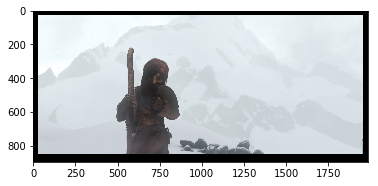

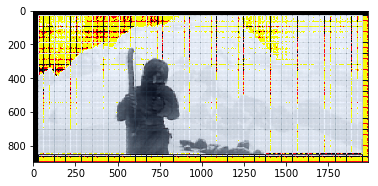

torch.Size([1, 896, 1984])


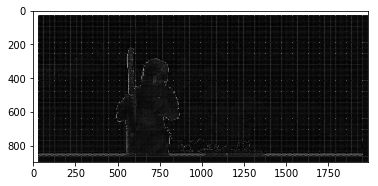

Frame 1


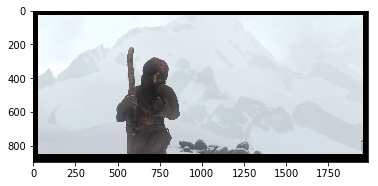

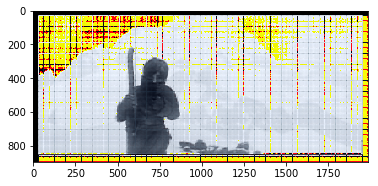

torch.Size([1, 896, 1984])


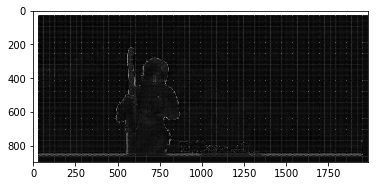

Frame 2


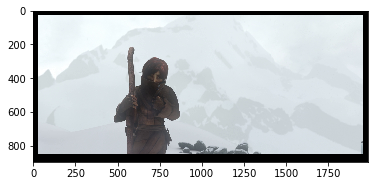

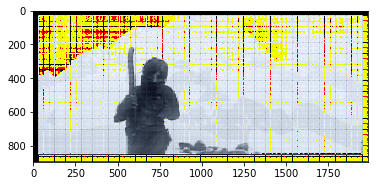

torch.Size([1, 896, 1984])


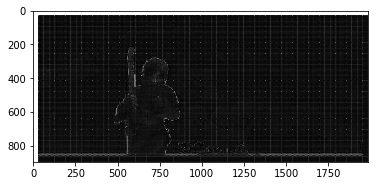

Frame 3


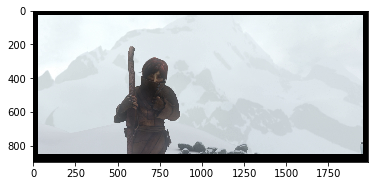

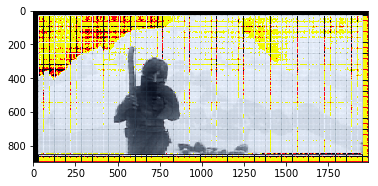

torch.Size([1, 896, 1984])


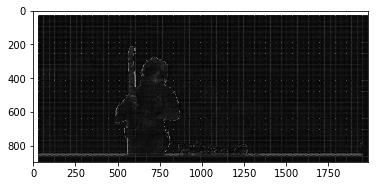

Frame 4


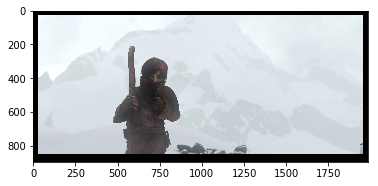

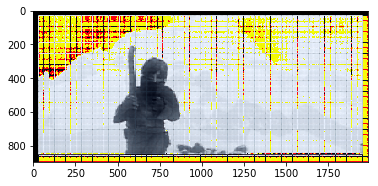

torch.Size([1, 896, 1984])


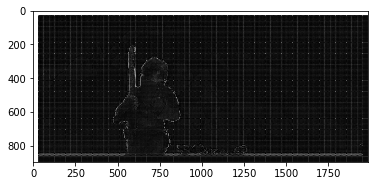

Frame 5


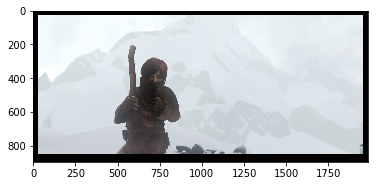

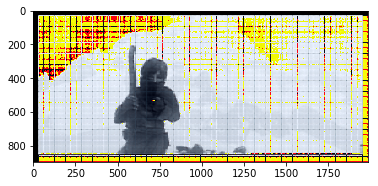

torch.Size([1, 896, 1984])


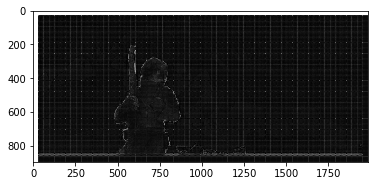

Frame 6


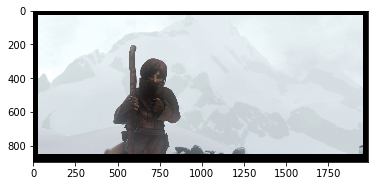

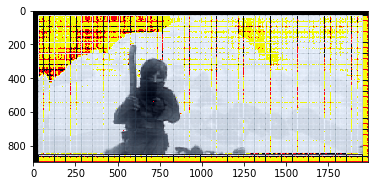

torch.Size([1, 896, 1984])


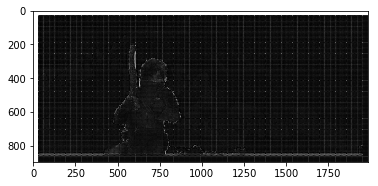

Frame 7


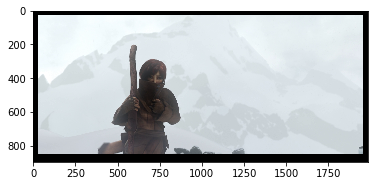

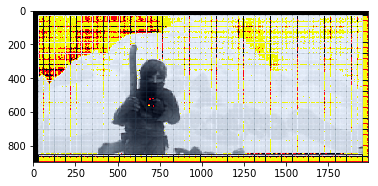

torch.Size([1, 896, 1984])


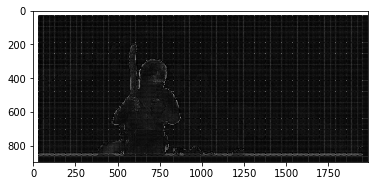

Frame 8


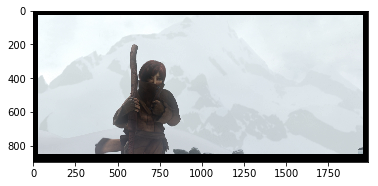

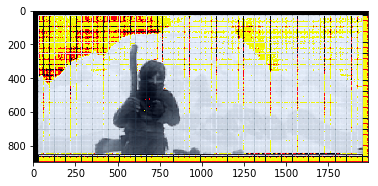

torch.Size([1, 896, 1984])


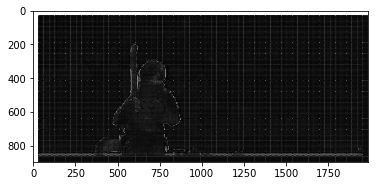

Frame 9


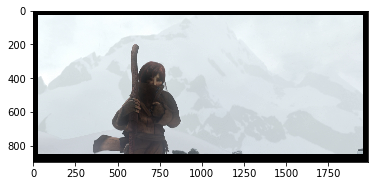

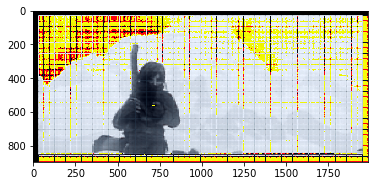

torch.Size([1, 896, 1984])


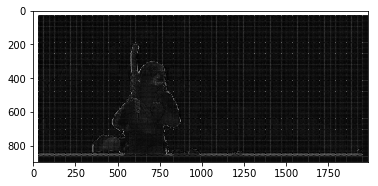

Frame 10


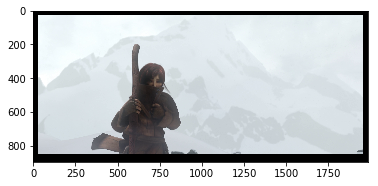

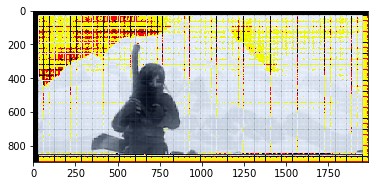

torch.Size([1, 896, 1984])


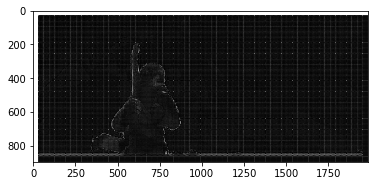

Frame 11


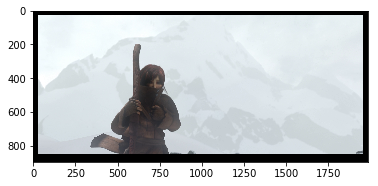

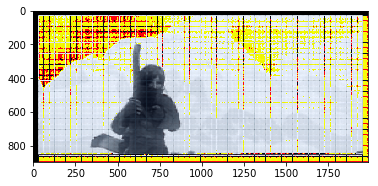

torch.Size([1, 896, 1984])


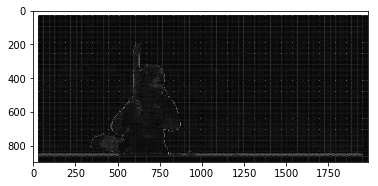

Frame 12


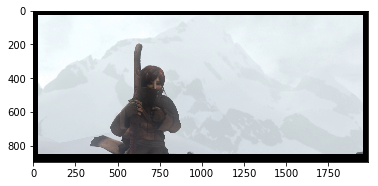

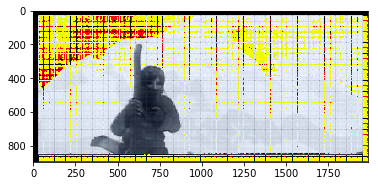

torch.Size([1, 896, 1984])


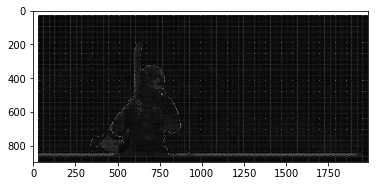

Frame 13


KeyboardInterrupt: 

In [22]:
test_loader = load_videos("seqs/full/test.txt", 30)
test_video = next(iter(test_loader))[0]

with torch.no_grad():
    test(model, test_video)